This is just a WIP script to visualized computed results.

In [2]:
# dependencies

from src.data_analysis.query_accuracy import query_accuracy
import matplotlib.pyplot as plt
import glob
from copy import copy
import numpy as np
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid


%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 4]
plt.style.use("bmh")

In [3]:
# show a face from each condition
def show_faces_of_condition(
    condition: str, suffixes: list, grid_size: tuple, figsize: tuple = (6, 8)
):
    potential_faces = glob.glob("Datasets//lfw//**//*.jpg", recursive=True)
    face_real_path = potential_faces[np.random.randint(len(potential_faces))]

    face_images = []

    for suffix in suffixes:
        dataset_name = f"lfw_{condition}_{suffix}"
        current_path = face_real_path.replace(
            "Datasets//lfw", f"Anonymized Datasets//{dataset_name}"
        )

        face_img = cv2.imread(current_path)
        face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        face_images.append(face_img)

    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(
        fig,
        111,  # similar to subplot(111)
        nrows_ncols=grid_size,  # creates 2x2 grid of axes
        axes_pad=0.1,  # pad between axes in inch.
    )

    while len(face_images) < grid_size[0] * grid_size[1]:
        face_images.append(np.zeros_like(face_images[0]))
        suffixes.append(-1)

    for i, (ax, im) in enumerate(zip(grid, face_images)):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.text(10, 30, suffixes[i], color="b")
        ax.set_xticks([])
        ax.set_yticks([])

    grid[0].set_title(condition)
    plt.show()

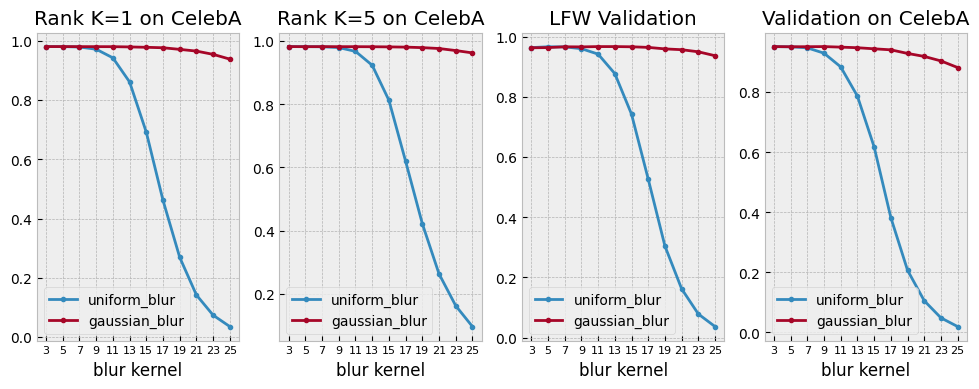

In [12]:
# looking at blurring results, comparing rank k on CelebA to lfw validation
fig, ax = plt.subplots(1, 4)

for privacy_mechanism in ["uniform_blur", "gaussian_blur"]:
    blur_kernels = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]

    # having to find the actual number of entries in CelebA's test set
    celeba_paths = glob.glob("Datasets//CelebA//**//*.jpg", recursive=True)
    rank_k_denominator = len(celeba_paths[182638:])

    zeros = [0 for _ in range(len(blur_kernels))]
    rank_k_accs, rank_k5_accs, val_accs, val2_accs = (
        copy(zeros),
        copy(zeros),
        copy(zeros),
        copy(zeros),
    )

    for i in range(len(blur_kernels)):
        kernel = blur_kernels[i]
        try:
            rank_k_accuracies = query_accuracy(
                "rank_k",
                dataset="CelebA",
                p_mech_suffix=f"{privacy_mechanism}_{kernel}",
                mode="mean",
                denominator=rank_k_denominator,
            )
            rank_k_accs[i] = rank_k_accuracies["1"]
            rank_k5_accs[i] = rank_k_accuracies["5"]
        except Exception:
            print(f"No data for {privacy_mechanism}_{kernel}.")

        try:
            val_acc = query_accuracy(
                "lfw_validation",
                dataset="lfw",
                p_mech_suffix=f"{privacy_mechanism}_{kernel}",
                mode="mean",
                denominator=3000,
            )
            val_accs[i] = val_acc
        except Exception:
            print(f"No data for {privacy_mechanism}_{kernel}.")

        try:
            val2_acc = query_accuracy(
                "validation",
                dataset="CelebA",
                p_mech_suffix=f"{privacy_mechanism}_{kernel}",
                mode="mean",
                denominator=5000,
            )
            val2_accs[i] = val2_acc
        except Exception:
            print(f"No data for {privacy_mechanism}_{kernel}.")

    ax[0].plot(blur_kernels, rank_k_accs, label=privacy_mechanism, marker=".")
    ax[1].plot(blur_kernels, rank_k5_accs, label=privacy_mechanism, marker=".")
    ax[2].plot(blur_kernels, val_accs, label=privacy_mechanism, marker=".")
    ax[3].plot(blur_kernels, val2_accs, label=privacy_mechanism, marker=".")

ax[0].set_title("Rank K=1 on CelebA")
ax[0].legend()
ax[1].set_title("Rank K=5 on CelebA")
ax[1].legend()
ax[2].set_title("LFW Validation")
ax[2].legend()
ax[3].set_title("Validation on CelebA")
ax[3].legend()

for i in range(4):
    ax[i].set_xticks(blur_kernels, labels=blur_kernels, fontsize=8)
    ax[i].set_xlabel("blur kernel")

plt.show()

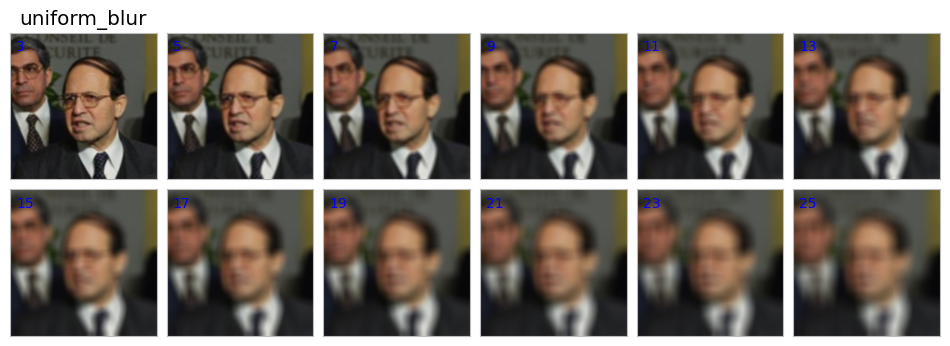

In [5]:
show_faces_of_condition(
    "uniform_blur", [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25], (2, 6), (12.0, 12.0)
)

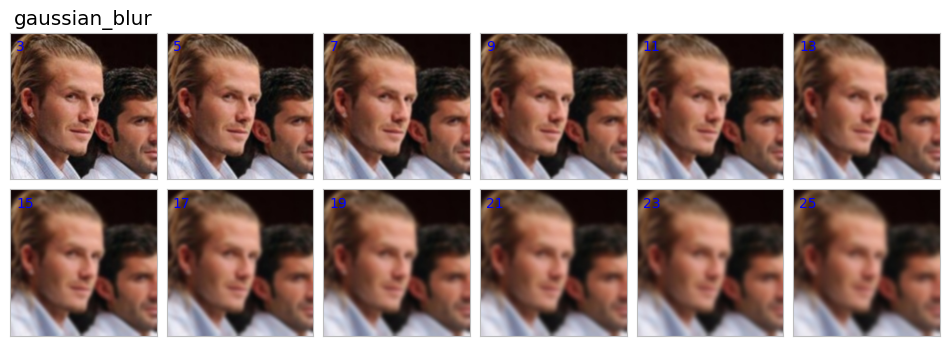

In [6]:
show_faces_of_condition(
    "gaussian_blur", [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25], (2, 6), (12.0, 12.0)
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


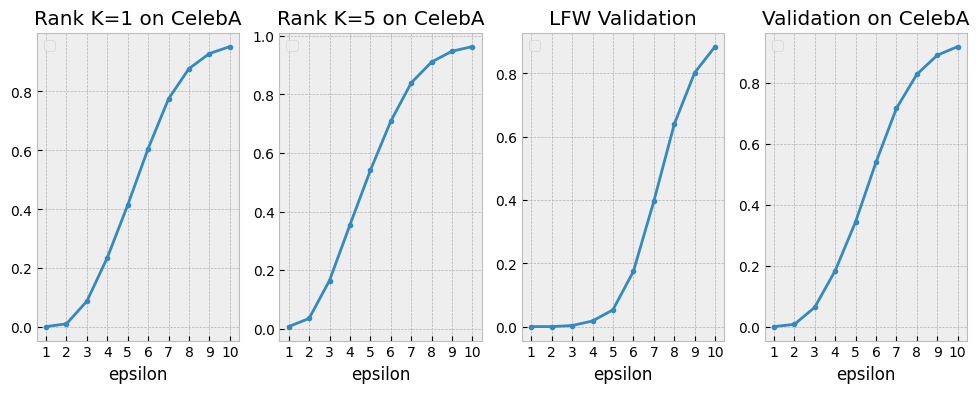

In [8]:
# look at pixel dp
fig, ax = plt.subplots(1, 4)

dp_epsilons = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

# having to find the actual number of entries in CelebA's test set
celeba_paths = glob.glob("Datasets//CelebA//**//*.jpg", recursive=True)
rank_k_denominator = len(celeba_paths[182638:])

zeros = [0 for _ in range(len(dp_epsilons))]
rank_k_accs, rank_k5_accs, val_accs, val2_accs = (
    copy(zeros),
    copy(zeros),
    copy(zeros),
    copy(zeros),
)

for i in range(len(dp_epsilons)):
    eps = dp_epsilons[i]
    try:
        rank_k_accuracies = query_accuracy(
            "rank_k",
            dataset="CelebA",
            p_mech_suffix=f"pixel_dp_{eps}",
            mode="mean",
            denominator=rank_k_denominator,
        )
        rank_k_accs[i] = rank_k_accuracies["1"]
        rank_k5_accs[i] = rank_k_accuracies["5"]
    except Exception:
        print(f"No data for pixel_dp_{eps}.")

    try:
        val_acc = query_accuracy(
            "lfw_validation",
            dataset="lfw",
            p_mech_suffix=f"pixel_dp_{eps}",
            mode="mean",
            denominator=3000,
        )
        val_accs[i] = val_acc
    except Exception:
        print(f"No data for pixel_dp_{eps}.")

    try:
        val2_acc = query_accuracy(
            "validation",
            dataset="CelebA",
            p_mech_suffix=f"pixel_dp_{eps}",
            mode="mean",
            denominator=5000,
        )
        val2_accs[i] = val2_acc
    except Exception:
        print(f"No data for pixel_dp_{eps}.")

ax[0].plot(dp_epsilons, rank_k_accs, marker=".")
ax[1].plot(dp_epsilons, rank_k5_accs, marker=".")
ax[2].plot(dp_epsilons, val_accs, marker=".")
ax[3].plot(dp_epsilons, val2_accs, marker=".")

ax[0].set_title("Rank K=1 on CelebA")
ax[0].legend()
ax[1].set_title("Rank K=5 on CelebA")
ax[1].legend()
ax[2].set_title("LFW Validation")
ax[2].legend()
ax[3].set_title("Validation on CelebA")
ax[3].legend()

for i in range(4):
    ax[i].set_xticks(dp_epsilons)
    ax[i].set_xlabel("epsilon")

plt.show()

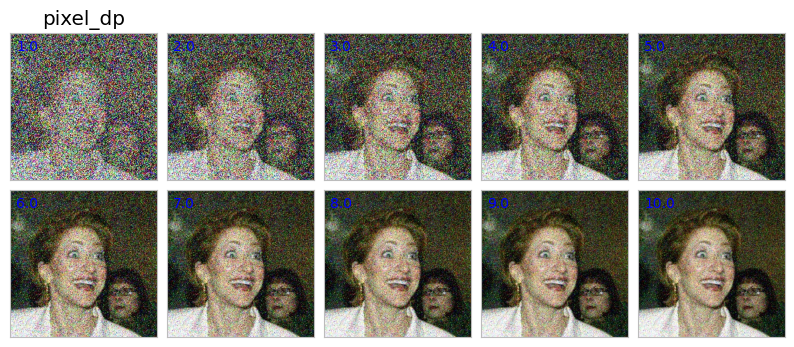

In [13]:
show_faces_of_condition(
    "pixel_dp",
    [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
    (2, 5),
    (10.0, 10.0),
)